In [15]:
import cv2, os, numpy as np, shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [10]:
size = 64
train_path = 'train'
test_path = 'sources/test64'

In [7]:
# if 'train' not in os.listdir():
#     os.mkdir('train')
#     os.mkdir('train/cat')
#     os.mkdir('train/dog')
#     for img in os.listdir(train_path):
#         if img[0] == 'c':
#             shutil.copy(f'{train_path}/{img}', f'train/cat/{img}')
#         else:
#             shutil.copy(f'{train_path}/{img}', f'train/dog/{img}')
#     train_path = 'train'

In [122]:
train = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='training',
    seed=38,
    image_size=(size,size)
)
valid = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='validation',
    seed=38,
    image_size=(size,size)
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


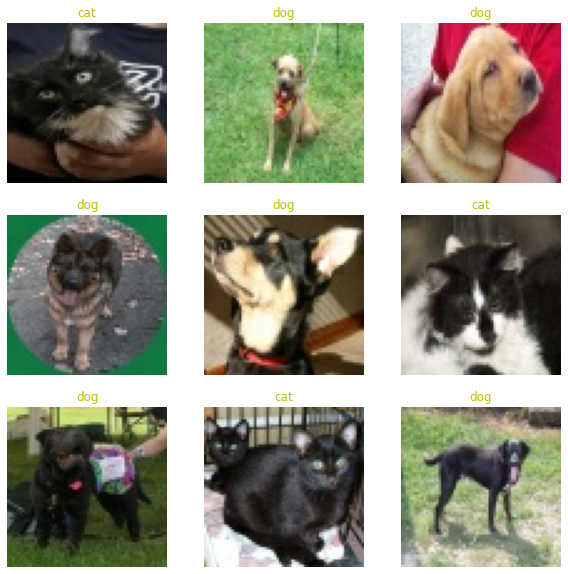

In [115]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train.class_names[labels[i]], color='y')
    plt.axis("off")

In [116]:
for element in train:
    print(element[0].shape)
    break

(32, 64, 64, 3)


In [42]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid = valid.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
# train = train.map(lambda x, y: (layers.Rescaling(1/255)(x), y))

In [50]:
#TensorFlow dokumentáció minta
model = keras.models.Sequential([
    layers.RandomFlip("horizontal", input_shape=(size, size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1/255, input_shape=(64, 64, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                  

In [52]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
history = model.fit(
    train, validation_data=valid, epochs=10
)

Epoch 1/10
625/625 [==============================] - 36s 56ms/step - loss: 0.6255 - accuracy: 0.6451 - val_loss: 0.5435 - val_accuracy: 0.7314
Epoch 2/10
625/625 [==============================] - 34s 54ms/step - loss: 0.5475 - accuracy: 0.7228 - val_loss: 0.5148 - val_accuracy: 0.7540
Epoch 3/10
625/625 [==============================] - 33s 53ms/step - loss: 0.5114 - accuracy: 0.7484 - val_loss: 0.4566 - val_accuracy: 0.7902
Epoch 4/10
625/625 [==============================] - 32s 51ms/step - loss: 0.4838 - accuracy: 0.7656 - val_loss: 0.4302 - val_accuracy: 0.8026
Epoch 5/10
625/625 [==============================] - 32s 51ms/step - loss: 0.4593 - accuracy: 0.7806 - val_loss: 0.4082 - val_accuracy: 0.8194
Epoch 6/10
625/625 [==============================] - 32s 51ms/step - loss: 0.4431 - accuracy: 0.7920 - val_loss: 0.3836 - val_accuracy: 0.8322
Epoch 7/10
625/625 [==============================] - 32s 52ms/step - loss: 0.4295 - accuracy: 0.8010 - val_loss: 0.3779 - val_accuracy:

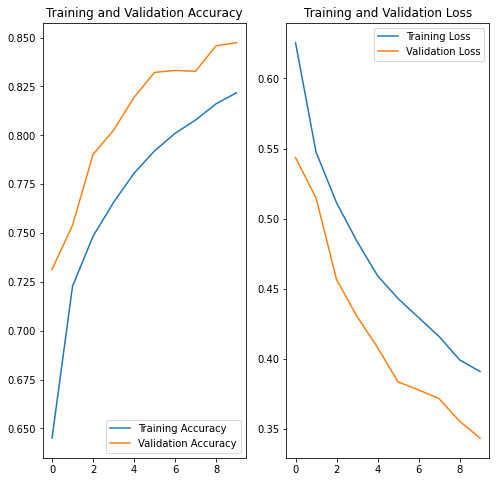

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

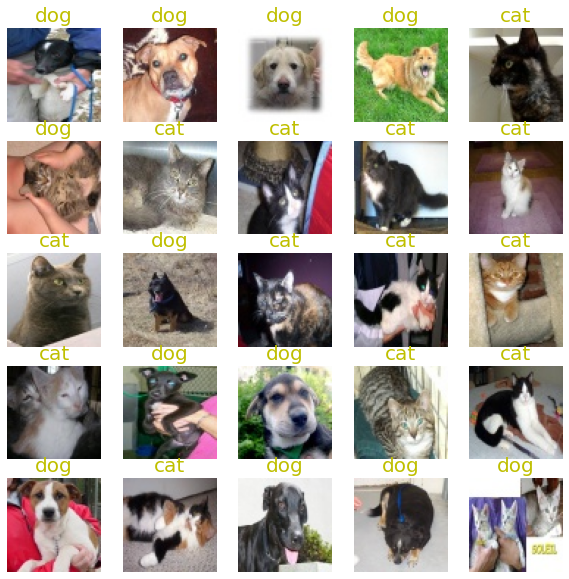

In [120]:
images_pred = [keras.utils.load_img(f'{test_path}/{i}.jpg') for i in range(1,26)]
arrays_pred = [keras.utils.img_to_array(img) for img in images_pred]
arrays_pred = [tf.expand_dims(arr, 0) for arr in arrays_pred]
labels_pred = [['cat', 'dog'][np.argmax(tf.nn.softmax(model.predict(arr)[0]))] for arr in arrays_pred]
predictions = list(map(lambda x, y:(x,y), images_pred, labels_pred))
plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images_pred[i])
    plt.title(labels_pred[i], fontdict={'fontsize': 20, 'fontweight' : 10, 'verticalalignment': 'baseline'}, color='y')
    plt.axis('off')


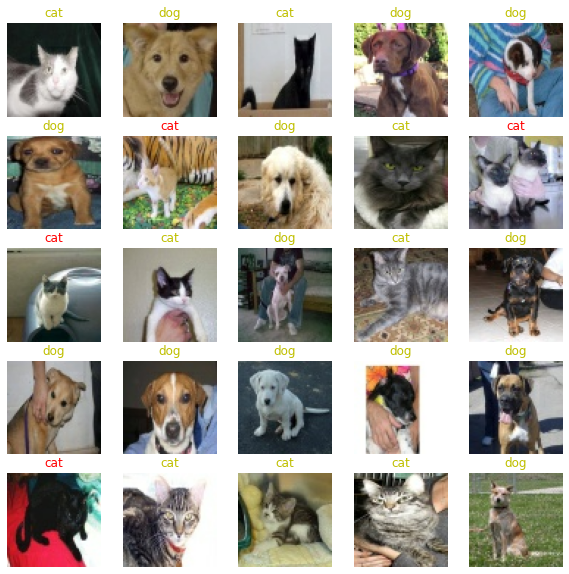

In [138]:
plt.figure(figsize=(10, 10))
for images, labels in valid.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    img = images[i].numpy().astype("uint8")
    lbl = train.class_names[labels[i]]
    plt.imshow(img)
    img = tf.expand_dims(keras.utils.img_to_array(img), 0)
    color= 'y' if ['cat', 'dog'][np.argmax(tf.nn.softmax(model.predict(img)))]==lbl else 'r'
    plt.title(lbl, color=color)
    plt.axis("off")

In [108]:
model2 = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(size, size, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])

In [109]:
model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer='adam',
               metrics=['accuracy'])

In [110]:
history = model2.fit(train, validation_data=valid, epochs=5)

Epoch 1/5
625/625 [==============================] - 45s 71ms/step - loss: 0.6951 - accuracy: 0.6360 - val_loss: 0.5831 - val_accuracy: 0.7120
Epoch 2/5
625/625 [==============================] - 43s 69ms/step - loss: 0.5680 - accuracy: 0.7134 - val_loss: 0.5450 - val_accuracy: 0.7320
Epoch 3/5
625/625 [==============================] - 41s 66ms/step - loss: 0.5245 - accuracy: 0.7494 - val_loss: 0.4975 - val_accuracy: 0.7604
Epoch 4/5
625/625 [==============================] - 42s 66ms/step - loss: 0.4855 - accuracy: 0.7725 - val_loss: 0.4700 - val_accuracy: 0.7840
Epoch 5/5
625/625 [==============================] - 41s 66ms/step - loss: 0.4562 - accuracy: 0.7929 - val_loss: 0.4401 - val_accuracy: 0.8054


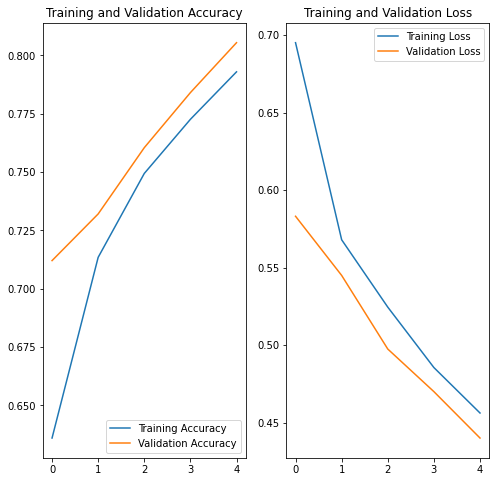

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()